In [1]:
from anndata import AnnData
from muon import prot as pt
from scipy.stats import pearsonr, spearmanr, wilcoxon

import os
os.environ["DASK_DATAFRAME__QUERY_PLANNING"] = "False"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import os, warnings 
warnings.filterwarnings('ignore') 

import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi


## Loading ST dataset

In [2]:
sample_list = ["CytAssist_FFPE_Protein_Expression_Human_Tonsil",
               "CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns",
               "CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer"]
n = len(sample_list)

In [3]:
# Input of STAN
adatas = dict()
pdatas = dict()

for sample_id in sample_list[:3]:
    adata, pdata = stan.read_cytassist('data/'+sample_id, min_cells=5, min_counts=500, remove_isotype=True)
    adatas[sample_id] = adata
    pdatas[sample_id] = pdata

In [4]:
adatas_stan = dict()
adatas_tfa = dict()
adatas_tfa_ridge = dict()
adatas_tfa_dec = dict()
for sample_id in sample_list:
    adata = sc.read_h5ad(f"outputs_stan/adata_{sample_id}.h5ad")
    adata.obsm['tfa_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_tfa_ridge.csv', index_col=0)
    adata.obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_{sample_id}_pred_cor_ridge.csv', index_col=0)
    adata.obsm['ulm_estimate'] = pd.read_csv(f'benchmark_decoupler/ulm_{sample_id}.csv', index_col=0).loc[adata.obs.index,:]
    adatas_tfa[sample_id] = stan.get_activity(adata, key='tfa_stan') 
    adatas_tfa_ridge[sample_id] = stan.get_activity(adata, key='tfa_ridge')
    adatas_tfa_dec[sample_id] = stan.get_activity(adata, key='ulm_estimate')
    adatas_stan[sample_id] = adata

For mRNA expression, normalize each spot by total counts over all genes.

In [5]:
for sample_id in sample_list:
    sc.pp.normalize_total(adatas[sample_id])
    sc.pp.log1p(adatas[sample_id])
    sc.pp.scale(adatas[sample_id])
    
    sc.pp.normalize_total(adatas_stan[sample_id])
    sc.pp.log1p(adatas_stan[sample_id])
    sc.pp.scale(adatas_stan[sample_id])
    
    pt.pp.clr(pdatas[sample_id])

### Images

Text(0, 0.5, '')

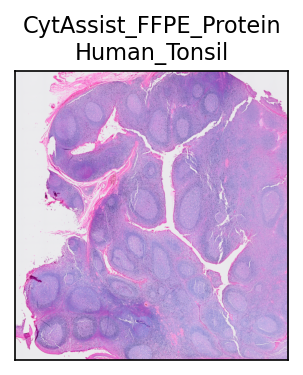

In [7]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas['CytAssist_FFPE_Protein_Expression_Human_Tonsil'], show=False, ax=ax, title="CytAssist_FFPE_Protein\nHuman_Tonsil")
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

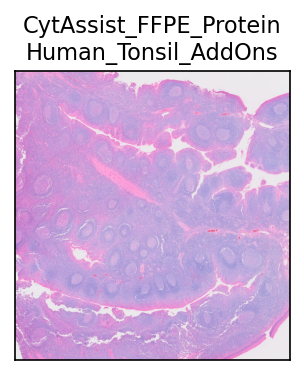

In [8]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas['CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns'], show=False, ax=ax, title="CytAssist_FFPE_Protein\nHuman_Tonsil_AddOns")
ax.set_xlabel("")
ax.set_ylabel("")

Text(0, 0.5, '')

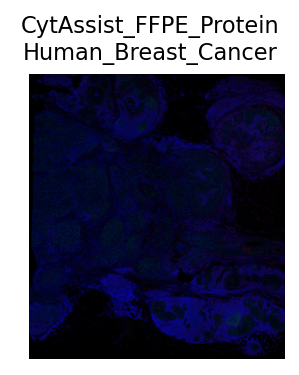

In [9]:
fig, ax = plt.subplots(1,1, figsize=(figsize, figsize), dpi=dpi)
plt.rc('font', size=fontsize) 
sc.pl.spatial(adatas['CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer'], show=False, frameon=False, ax=ax, title="CytAssist_FFPE_Protein\nHuman_Breast_Cancer")
ax.set_xlabel("")
ax.set_ylabel("")

## Cross validation performance

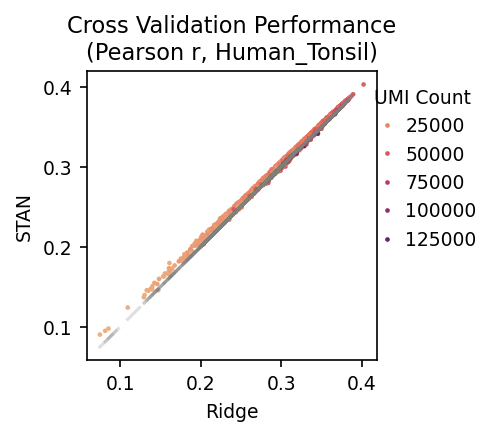

In [6]:
stan.plot_validation(adatas_stan['CytAssist_FFPE_Protein_Expression_Human_Tonsil'], 
                     title='Cross Validation Performance\n(Pearson r, Human_Tonsil)')

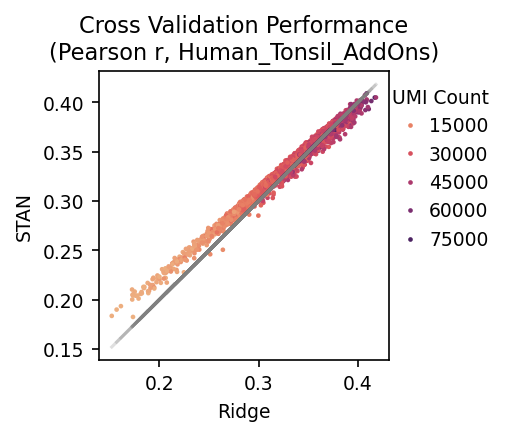

In [7]:
stan.plot_validation(adatas_stan['CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns'], 
                     title='Cross Validation Performance\n(Pearson r, Human_Tonsil_AddOns)')

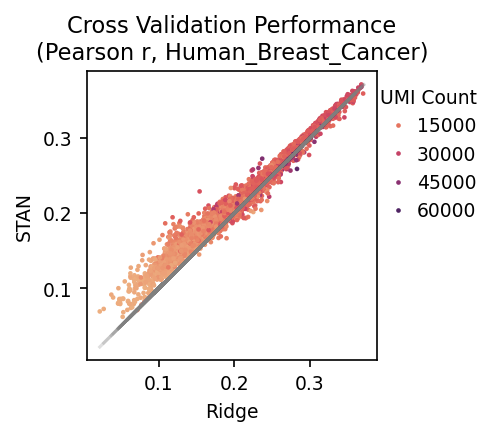

In [8]:
stan.plot_validation(adatas_stan['CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer'], 
                     title='Cross Validation Performance\n(Pearson r, Human_Breast_Cancer)')

In [22]:
for sample_id in sample_list:
    print(sample_id)
    print(adatas_stan[sample_id].obs["pred_cor_stan"].mean())
    print(adatas_stan[sample_id].obs["pred_cor_stan"].std())
    print(adatas_stan[sample_id].obs["pred_cor_ridge"].mean())
    print(adatas_stan[sample_id].obs["pred_cor_ridge"].std())

CytAssist_FFPE_Protein_Expression_Human_Tonsil
0.31018062076783
0.0381996874097389
0.30665304137155924
0.039304168252492874
CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns
0.33620995932103875
0.030485924952155064
0.3300489927843274
0.0346351929933098
CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer
0.20580275435340145
0.05459945000471552
0.19188093853105836
0.06134724325750473


In [20]:
for sample_id in sample_list:
    print(sample_id)
    print(wilcoxon(adatas_stan[sample_id].obs["pred_cor_stan"], adatas_stan[sample_id].obs["pred_cor_ridge"],
          zero_method='wilcox', correction=False, alternative='greater'))

CytAssist_FFPE_Protein_Expression_Human_Tonsil
WilcoxonResult(statistic=8733747.0, pvalue=0.0)
CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns
WilcoxonResult(statistic=11178240.0, pvalue=0.0)
CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer
WilcoxonResult(statistic=8407379.0, pvalue=0.0)


## Correlation with PAX5

In [9]:
def make_dataframe_expression(sample_id, target='PAX5'):
    
    adata = adatas[sample_id]
    pdata = pdatas[sample_id]
    
    df = pd.DataFrame(index=adata.obs_names, columns = ['Protein', 'mRNA', 'STAN', 'Ridge', 'DecoupleR'])
    df['Protein'] = pdata.to_df()[target+'-1']
    df['mRNA'] = adata.to_df()[target]
    
    adata_tfa_scaled = adatas_tfa[sample_id].copy()
    # sc.pp.scale(adata_tfa_scaled)
    df['STAN'] = adata_tfa_scaled[:,target].to_df()
    
    adata_tfa_scaled = adatas_tfa_ridge[sample_id].copy()
    # sc.pp.scale(adata_tfa_scaled)
    df['Ridge'] = adata_tfa_scaled[:,target].to_df()
    
    del adata_tfa_scaled
    adata_tfa_scaled = adatas_tfa_dec[sample_id].copy()
    # sc.pp.scale(adata_tfa_scaled)
    df['DecoupleR'] = adata_tfa_scaled[:,target].to_df()
    return df

In [10]:
df_list = dict()
for sample_id in sample_list:
    df_list[sample_id] = make_dataframe_expression(sample_id, target='PAX5')
    
df_cor = pd.DataFrame(index=sample_list, columns = ['mRNA', 'STAN', 'Ridge', 'DecoupleR'])
for sample_id in df_cor.index:
    for method in df_cor.columns:
        df_cor.loc[sample_id, method] = spearmanr(df_list[sample_id]['Protein'], df_list[sample_id][method])[0]


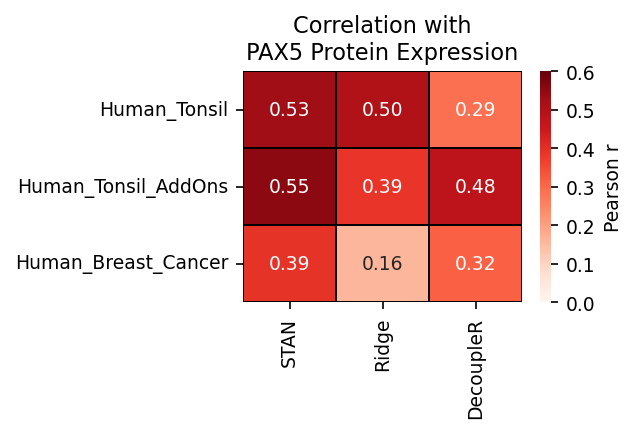

In [18]:
df_cor.index = ["Human_Tonsil", "Human_Tonsil_AddOns", "Human_Breast_Cancer"]
plt.figure(figsize=(figsize*1.2, figsize*0.8), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(df_cor.iloc[:,1:].astype(float), annot=True, cmap="Reds", vmax=0.6, vmin=0, fmt='.2f',
                 linewidths=0.8, linecolor='black')
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation with\nPAX5 Protein Expression')
colorbar = ax.collections[0].colorbar
colorbar.set_label('Pearson r', fontsize=fontsize)

In [12]:
for sample_id in sample_list:
    for col in ['Protein', 'mRNA', 'STAN', 'Ridge', 'DecoupleR']:
        if col in adatas_tfa[sample_id].obs.columns:
            adatas_tfa[sample_id].obs[col] = df_list[sample_id][col]
        else:
            adatas_tfa[sample_id].obs = adatas_tfa[sample_id].obs.join(df_list[sample_id][col])

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spatial(adata_tfa, sample_id, target='PAX5'):
    fig, axes = plt.subplots(1, 4, figsize=(figsize*4, figsize), dpi=dpi)
    plt.rc('font', size=fontsize) 
    targets = ['Protein', 'STAN', 'Ridge', 'DecoupleR']
    cmaps = ["YlGnBu_r", "plasma", "plasma", "plasma"]
    
    for i, (target_name, cmap) in enumerate(zip(targets, cmaps)):
        # Plot the spatial data
        sc.pl.spatial(adata_tfa, color=target_name, alpha_img=0, ax=axes[i], show=False, cmap=cmap, 
                       legend_fontsize=fontsize, size=1.8, colorbar_loc=None)
        
        # Create a divider for the existing axes
        divider = make_axes_locatable(axes[i])
        
        # Add a new axes to the right of the main axes for the colorbar
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        # Get the mappable object (the plot data)
        mappable = axes[i].collections[0]
        
        # Create the colorbar in the new axes
        cbar = plt.colorbar(mappable, cax=cax)
        
        # Adjust the colorbar height to match the frame height
        cbar.ax.set_position([1.01, 0, 0.05, 1])  # [x, y, width, height]
        
        # Set titles for each subplot
        
        # Remove x and y labels
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        
    axes[0].set_title('PAX5 protein expression')
    axes[1].set_title('STAN-inferred PAX5 activity')
    axes[2].set_title('Ridge-inferred PAX5 activity')
    axes[3].set_title('DecoupleR-inferred PAX5 activity')
    
    # Set the main title for the figure
    # plt.suptitle('{} Expression and Inferred Activity ({})'.format(target, sample_id), fontsize=fontsize*1.2)
    plt.suptitle(f"{sample_id}\n", fontsize=fontsize*1.2)
    plt.tight_layout(pad=0.6)
    plt.show()

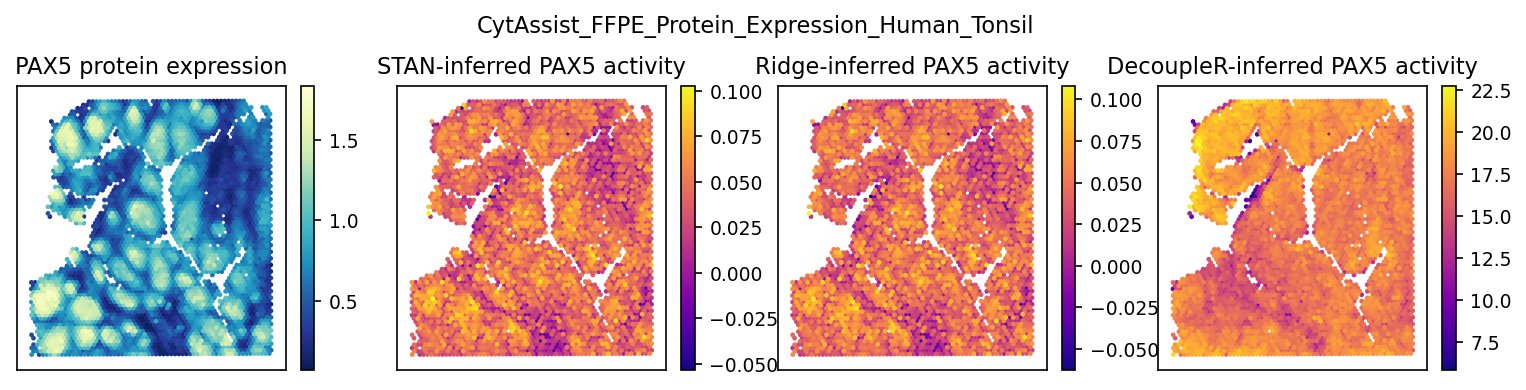

In [14]:
plot_spatial(adatas_tfa['CytAssist_FFPE_Protein_Expression_Human_Tonsil'], 'CytAssist_FFPE_Protein_Expression_Human_Tonsil')

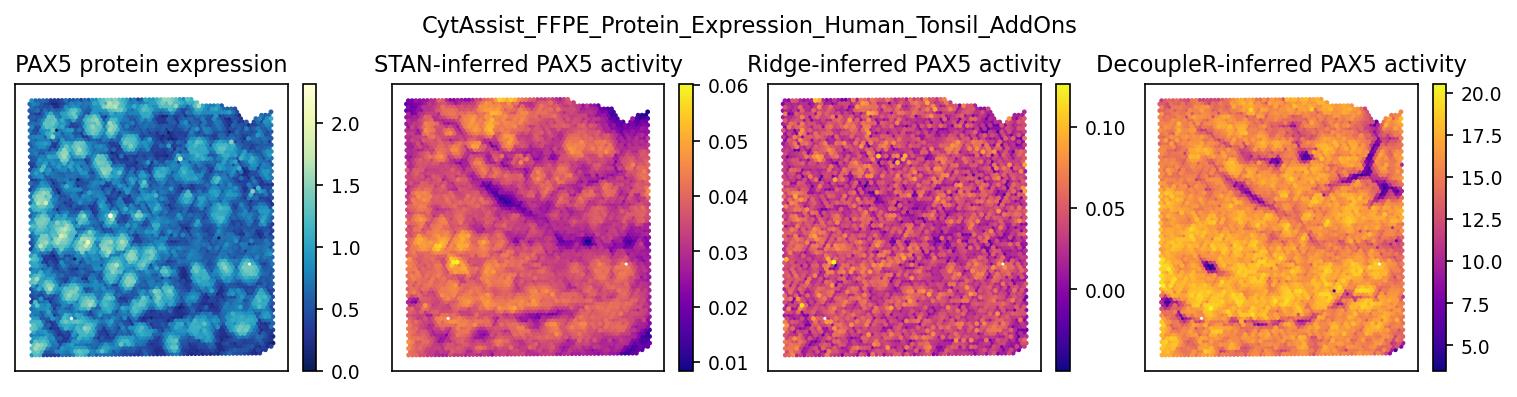

In [15]:
plot_spatial(adatas_tfa['CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns'], 'CytAssist_FFPE_Protein_Expression_Human_Tonsil_AddOns')

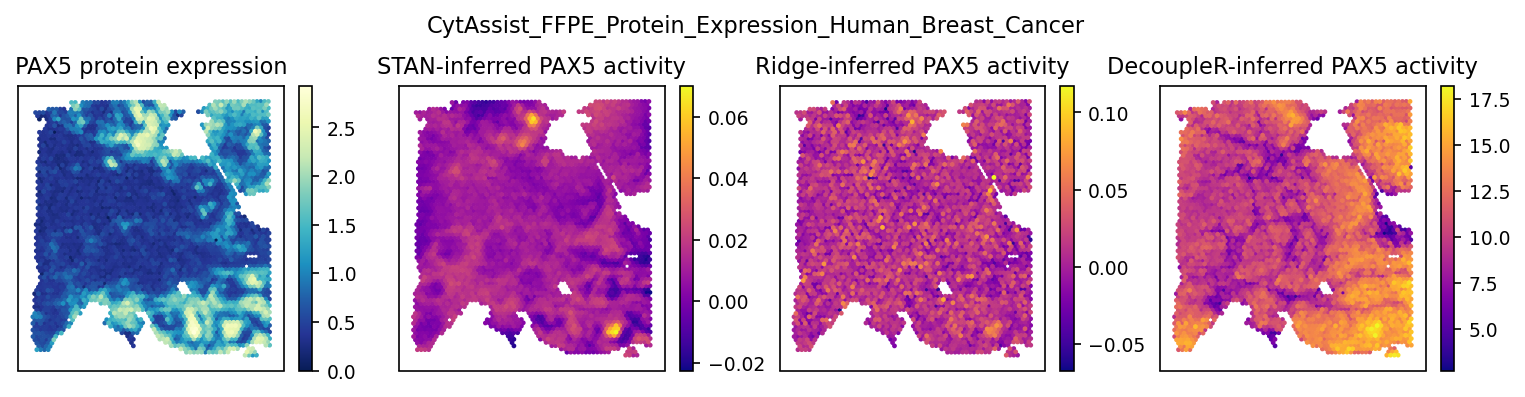

In [16]:
plot_spatial(adatas_tfa['CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer'], 'CytAssist_FFPE_Protein_Expression_Human_Breast_Cancer')